---
## PROJECT DESCRIPTION AND SUMMARY 
---

 Early detection of skin cancer has the potential to reduce mortality and morbidity. Dermoscopy technique is widely used for image acquisition in diagnosis of skin cancer. Artefacts such as air bubbles, ruler markings and hair which are covering skin affect the segmentation process. This report presents two hybrid techniques for the classiﬁcation of the skin images to predict it if exists. The proposed hybrid techniques consists of three stages, namely, Image processing and feature extraction, dimensionality reduction, and classiﬁcation. 

 In the ﬁrst stage, we have obtained the features related with images using pixel value extraction. In the second stage, the features of skin images were reduced using principle component analysis to the more essential features. In the classiﬁcation stage, three classiﬁers based on supervised machine learning were developed namely k-nearest neighbour, logistic regression and svm.
 
 The classiﬁers were used to classify the images as benign or malignant skin cancer images and were nominally represented as 1 and 0 respectively. The first goal was to determine whether the test images were benign or malignant after being trained on the train set. The minimum image dimension was determined from the image set and was used to rescale the other images to 450x600 pixels and greyscaled in order to reduce the number of channels. 

In [2]:
from IPython.display import HTML
import random

# Create function to enable hiding of input cell

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle to show/hide code'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

In [3]:
#Import Necessary Libraries 
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import seaborn as sns
from skimage.io import imread, imshow
%matplotlib inline
from PIL import Image
from skimage.feature import hog 
import skimage
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import fnmatch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import os
import sys
import cv2
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings("ignore")
hide_toggle()

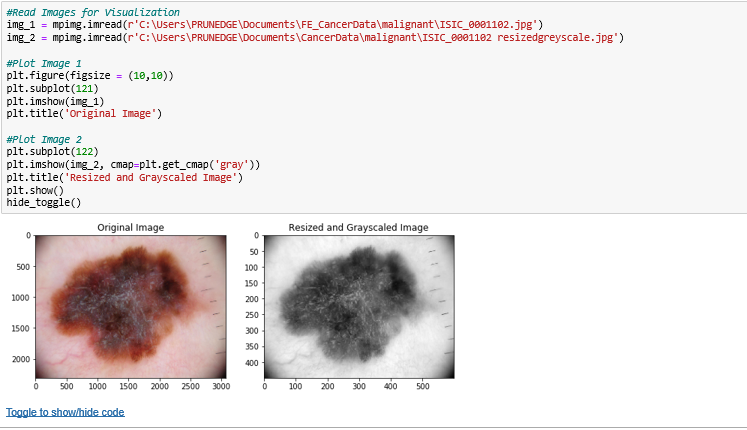

This created a feature size of 27000 and had to be shrunk and normally scaled. PCA was used to determine the features that accounted for 90% of the variance which were discovered to be 23. 
 
 This were then labelled and the dataset was then split into train and test sets which were subsequently fed into the classification models and evaluated based on their accuracy, precision, recall and F-1 scores where their hyperparameters were tuned using GridSearch. This was then cross-validated on 10 iterations and it was proved that K nearest neighbour performed best with an accuracy of 63.3% and cross validation score of 59.6%.
 
 The second goal was accomplished by using a different approach of feature extraction. Histogram of Gradients (HOG) was used to extract the gradient and orientation of the image edges in order to describe the image features. A number of Image pre-processing techniques were considered to minimise Image noise such as ruler markings, hair, air bubbles, poor lighting among others. They include resizing the images to 100x100 pixels, using only the blue channel for the images, morphological closing by using dilation to segment the lesions from the skin and Contrast Limited Adaptive Histogram Equalization (CLAHE) balance the image lighting.

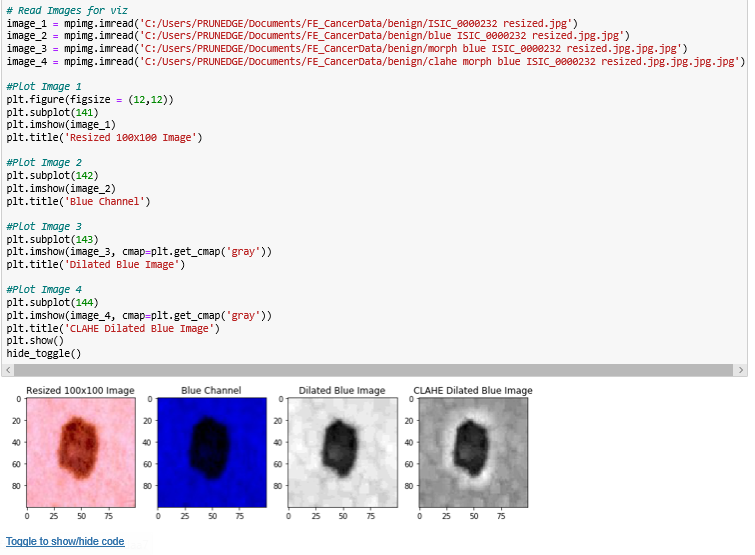

This subsequently generated >4000 features and the labels were added and splitted 70-30% for train and test respectively. K- Nearest Neighbour would expectedly perform poorly due to the large number of features so Gaussian Naive Bayes was used and performed best with an accuracy of 67.7% and cross-validation score of 75.7% which is a clear improvement over the previous method. 

----
## DATA PROCESSING
---

Please enter path to Images

In [6]:
#Request for path for original and duplicate of malignant and benign Images 
path_non_FE_malignant = input('Enter path to first CancerData malignant images : ')
path_non_FE_benign =  input('Enter path to first CancerData benign images : ')

path_FE_malignant = input('Enter path to second CancerData malignant images : ')
path_FE_benign = input('Enter path to second CancerData benign images : ')


Enter path to first CancerData malignant images : C:/Users/PRUNEDGE/Documents/CancerData/malignant/
Enter path to first CancerData benign images : C:/Users/PRUNEDGE/Documents/CancerData/benign/
Enter path to second CancerData malignant images : C:/Users/PRUNEDGE/Documents/FE_CancerData/malignant/
Enter path to second CancerData benign images : C:/Users/PRUNEDGE/Documents/FE_CancerData/benign/


Exploratory data analysis (EDA) was performed on the benign and malignant images to determine their maximum and minimum dimension size. 

In [7]:
#create empty list to store width and height of all images
x = []
y = []

#List path for original malignant and benign images 
path = [path_non_FE_malignant, path_non_FE_benign]

#Loop for paths
for pat in path:
    dir = os.listdir(pat)
    # Take all images in each path, open and take height and width
    for item in dir:
        if os.path.isfile(pat+item):
            img = Image.open(pat+item)
            width, height = img.size
            #Apppend height and width to empty list 
            x.append(height)
            y.append(width)
    #print minimum and maximum image dimensions 
    print()
    print("Minimum Image Height: {}".format(min(x)))
    print("Minimum Image Width: {}".format(min(y)))
    print("Maximum Image Height: {}".format(max(x)))
    print("Maximum Image Width: {}".format(max(y)))
hide_toggle()


Minimum Image Height: 450
Minimum Image Width: 600
Maximum Image Height: 450
Maximum Image Width: 600

Minimum Image Height: 450
Minimum Image Width: 600
Maximum Image Height: 450
Maximum Image Width: 600


The minimum dimensions in both classes of images was 450x600, hence all the images from dataset were then scaled down to 450x600.

In [8]:
#Resize images

#Take each image for each path and resize to 600x450, rename and save image to the particular path
path = [path_non_FE_malignant, path_non_FE_benign]
for pat in path:
    dirs = os.listdir(pat)
    for item in dirs:
        if os.path.isfile(pat+item):
            im = Image.open(pat+item)
            f, e = os.path.splitext(pat+item)
            imResize = im.resize((600,450), Image.ANTIALIAS)
            imResize.save(f + ' resized.jpg', 'JPEG', quality=90)
hide_toggle()

In order to reduce computational cost and training time, the images were reduced to a single channel by converting to grayscale.

In [9]:
#Convert images to grayscale

# Take every image with term 'resized.jpg', convert to grayscale, rename and save image to the path
path = [path_non_FE_malignant, path_non_FE_benign]
for pat in path:
    dirs = os.listdir(pat)
    pattern = '*resized.jpg'
    for item in dirs:
        if fnmatch.fnmatch(item, pattern):
            f, e = os.path.splitext(pat+item)
            image = Image.open(pat+item).convert('L')
            image = image.save(f + 'greyscale.jpg', 'JPEG', quality=90)
hide_toggle()

The pixel values from the converted images were then extracted into an array and thereafter transformed into a dataframe with the class of each attached as the final column. The malignant class was 0 while the benign class was 1. This process was done for each class and concatenated to one dataframe containing 27000 features and 300 instances.

In [10]:
#Converting to grayscale
mal = []

#Search for images named with grayscale extract the pixel information from them and append them into empty list
path = path_non_FE_malignant
dirs = os.listdir(path)
pattern = '*greyscale.jpg'
for item in dirs:
    if fnmatch.fnmatch(item, pattern):
        mal_array = np.array(Image.open(path+item)).flatten()
        mal.append(mal_array)
#Covert list to numpy array        
malig = np.asarray(mal)
#Create dataframe with array  
malig_df = pd.DataFrame(data=malig[0:,0:],
                        index=[i for i in range(malig.shape[0])],
                        columns=[str(i) for i in range(malig.shape[1])])
#Add class 0 to final column of dataframe 
malig_df[len(malig_df.columns)] = 0

malig_df.head()

hide_toggle()

In [11]:
#Benign Dataframe
ben = []

#Search for images named with grayscale extract the pixel information from them and append them into empty list
path = path_non_FE_benign
dirs = os.listdir(path)
pattern = '*greyscale.jpg'
for item in dirs:
    if fnmatch.fnmatch(item, pattern):
        ben_array = np.array(Image.open(path+item)).flatten()
        ben.append(ben_array)
#Covert list to numpy array
benign = np.asarray(ben)
#Create dataframe with array  
benign_df = pd.DataFrame(data=benign[0:,0:],
                        index=[i for i in range(benign.shape[0])],
                        columns=[str(i) for i in range(benign.shape[1])])
#Add class 1 to final column of dataframe 
benign_df[len(benign_df.columns)] = 1
benign_df.head()

hide_toggle()

In [12]:
#COncatenate malignant and benign dataframes 
cancer_df = pd.concat([malig_df, benign_df], ignore_index=True, sort =False)
hide_toggle()

Since the number features in the dataframe was large, dimensional reduction would have to be performed and in order to prepare for this. Hence, the dataframe was scaled normally and classed. 

In [13]:
#Split dataframe into features and label
cancer_df_sliced = cancer_df.iloc[:,:-1]
df = cancer_df.iloc[:,-1]

#Scale features normally and transform to dataframe
cancer_norm = StandardScaler().fit_transform(cancer_df_sliced)
cancer_norm = pd.DataFrame(cancer_norm)
#Add labels to scaled dataframe
cancer_norm['270000'] = df.values

#Split scaled dataframe into feature and label
cancer_feature = cancer_norm.iloc[:,:-1]
cancer_label = cancer_norm.iloc[:,-1]
hide_toggle()

The dataframe was then randomly splitted into a training and test set in the ratio 70/30 respectively with PCA applied to the feature train set in order to determine the features that accounted for 90% of the variance. It turns out that 23 features were responsible for this out of 27000 features. This was then used to transform the feature train and test. 

In [14]:
#Split feature and label into train and test set 
x_train, x_test, y_train, y_test = train_test_split(cancer_feature, cancer_label, test_size=0.30, random_state=30)

#Apply PCA to train set to determine features that account for 90% of the variance
pca = PCA(0.9)
pca.fit(x_train)
#Display number of components that account for this.
print('Number of Features that account for 90% variance: ', pca.n_components_)

#Remove other features 
train_img_pca = pca.transform(x_train)
test_img_pca = pca.transform(x_test)

hide_toggle()

Number of Features that account for 90% variance:  23


---
## CLASSIFICATION MODEL BASED ON PIXELS
---

After processing the image features, the next step was to determine classifier algorithms which could properly classify the test image features after fitting on the train features. Three classifiers were then chosen; Logistic Regression, Support Vector Machines and K- Nearest Neighbour. 



Logistic Regression was the first base model and it was fitted with the transformed train features and the train class. The performance on the test set was measured on accuracy, precision, recall and f-1 score. Its hyper-parameters were manually tuned with C set to 1 after several predictions. Its performance was 0.589 accuracy, 0.55 precision, 0.537 recall and 0.54 f-1 score. 

Its area under curve (AUC) was also plotted to understand its predictions with a score of 0.68.

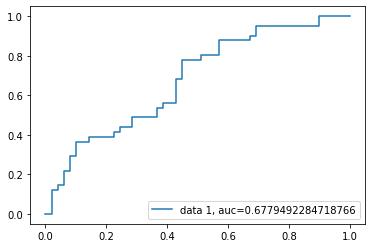

Accuracy: 0.5888888888888889
Precision: 0.55
Recall: 0.5365853658536586
f1-score: 0.54320987654321


In [15]:
#Apply logistic regression with parameter C=1
logreg = LogisticRegression(C=1)
#Fit train set
logreg.fit(train_img_pca,y_train)
#Predict test set
y_pred = logreg.predict(test_img_pca)

#Create AUC plot
y_pred_proba = logreg.predict_proba(test_img_pca)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#Show classification result 
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("f1-score:",metrics.f1_score(y_test, y_pred))
hide_toggle()

A confusion matrix was also plotted to understand the logistic regression predictions vs the actual class on whether it predicted correctly or falsely. It correctly predicted 31 instances as malignant and 22 ans benign while it incorrectly classified 18 malignant instances as benign and 19 benign instances as malignant.

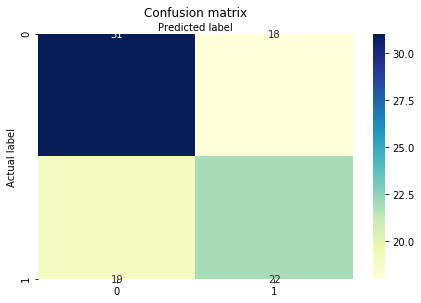

In [16]:
#Plot confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
hide_toggle()

The results were then cross-validated where the logistic regression model made predictions on the training set iteratively 10 times. The mean score of the iterations was then evaluated as 0.577.

In [17]:
#Determine validation score 
validation_score = cross_val_score(logreg, train_img_pca , y_train, cv = 10, scoring = 'accuracy').mean()
print('Logistic Regression Validation Score: ', validation_score)
hide_toggle()

Logistic Regression Validation Score:  0.5771428571428572


SVM was considered after and it was also fitted with the train set to predict the test set. Its hyperparameter was also manually tuned where its kernel was set to linear. It obtained an accuracy of 0.589, precision of 0.55, recall of 0.59 and f-1 score of 0.56 which were similar to what the logistic regression obtained.

In [18]:
#Apply SVM, fit on train set and predict test set 
clf = svm.SVC(kernel='linear') 
clf.fit(train_img_pca,y_train)
y_pred = clf.predict(test_img_pca)

#Display classification result 
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("f1-score:",metrics.f1_score(y_test, y_pred))

hide_toggle()

Accuracy: 0.5888888888888889
Precision: 0.5454545454545454
Recall: 0.5853658536585366
f1-score: 0.5647058823529411


According to the confusion matrix for SVM, it predicted malignant correctly 29 times and benign correctly 24 times. It misclassified benign as malignant 20 times and vice versa 17 times. 

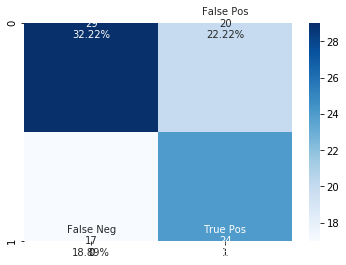

In [19]:
#Display confusion matrix for SVM
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
hide_toggle()

The SVM model was cross validated twice due to its computation time. It achieved a score of 0.576 which was also similar to the logistic regression.

In [20]:
#Display validation result
validation_score = cross_val_score(clf, train_img_pca , y_train, cv = 2, scoring = 'accuracy').mean()
print('SVM validation score: ', validation_score)
hide_toggle()

SVM validation score:  0.5761066763425253


The final classifier considered for the pixel-based approach was K nearest neighbour. It was expected to perform better due to its non-parametric and lazy method of classification which assumes no underlying distribution and the small number of features. It was fitted with its number of neighbours hyperparameter set to 7 by empirical deduction. Its accuracy was evaluated to 0.633, precision at 0.57, recall at 0.756 and f1-score at 0.653 which are improvement over the last two classifiers. Also noticeable was the relatively high recall which suggests it predicts benign correctly more of the time.

In [21]:
#Apply knn, fit on train set and predict test set.
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(train_img_pca,y_train)
y_pred = knn.predict(test_img_pca)

#Display classification result 
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("f1-score:",metrics.f1_score(y_test, y_pred))
hide_toggle()

Accuracy: 0.6333333333333333
Precision: 0.5740740740740741
Recall: 0.7560975609756098
f1-score: 0.6526315789473683


Its cross-validation score of 0.597 was marginally better than the other two which makes it the best classifier in this approach.  

In [23]:
#Determine and display validation result 
validation_score = cross_val_score(knn, train_img_pca , y_train, cv = 10, scoring = 'accuracy').mean()
print('K-NN validation score', validation_score)
hide_toggle()

K-NN validation score 0.5956926406926406


Its confusion matrix is displayed below. It has 31 True positive instances while it has 10 instances of False negatives which explains its high recall score.

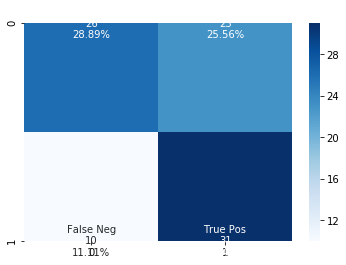

In [24]:
#Print confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
hide_toggle()

Outlined below is a table summary of the evaluation of classifier on accuracy, precision, recall and cross-validation metrics. K-NN performed best overall while SVM and Logistic Regression were mostly equal in performance.


|  Classifier  | Accuracy | Precision | Recall | F1 score | Cross-Validation score |
| --- | --- | --- | --- | --- | --- |
| Logistic Regression | 0.589 | 0.550 | 0.537 | 0.543 | 0.577
| SVM | 0.589 | 0.545 | 0.585 | 0.565 | 0.576
| K-NN | 0.633 | 0.574 | 0.756 | 0.653 | 0.596



The classifiers were also compared based on their confusion matrices and it was discovered that K-NN was a much better predictor of benign class while Logistic regression was better at predicting the malignant class.

|  Classifier  | True Negative (%) | False Positive (%) | False Negative (%) | True Positive (%) |
| --- | --- | --- | --- | --- |
| Logistic Regression | 34.44 | 20.00 | 21.11 | 24.44 |
| SVM |32.22  | 22.22 | 18.09 | 27.47 | 
| K-NN | 28.89 | 25.56 | 11.01 | 34.54


---
## LITERATURE REVIEW
---

There has been a number of papers published on classification of skin cancer images using machine learning methods and techniques to process and de-noise dermoscopic images. For machine learning methods, some include;
<ol><b>
<li>Deep Neural Networks</li>
<li>PCA</li>
    <li>Clustering</li></b>
</ol>

<b> Deep Neural Networks </b> (DNNs) uses novel designed transfer learning based deep neural network like skin_inceptions_v3_nn to help achieve a high prediction accuracy [1]. The melanoma recognition neural network (skin_recnn) is built based on the backbend of Google Inceptions V3 network. The output layer of Inceptions V3 is replaced by and full connection layers (1024 nodes) and the starting weight of the network is the well-trained weight from ImageNet datasets [1]. There are two Inceptions V3 neural networrk where one is in charge of full size dermoscopic images, the other one is in charge of cropped dermoscopic images from skin_segnn, which only maintained the major lesion region. Then both 1024 nodes are merged together and an output layer with 3 nodes. [1]

<b> Principal Component Analysis </b> (PCA)  The purpose of PCA is to reduce the large dimensionality of the data space (observed variables) to the smaller intrinsic dimensionality of feature space (independent variables), which are needed to describe the data economically. This is the case when there is a strong correlation between observed variables. [2] Because PCA is a classical technique which can do something in the linear domain, applications having linear models are suitable, such as signal processing, image processing, system and control theory, communications, etc. [2] Given a set of data, PCA ﬁnds the linear lower-dimensional representation of the data such that the variance of the reconstructed data is preserved. This leads to more efﬁcient and accurate classiﬁer. Below is an outline of the algorithm

<i> <b> Input: Data set(matrix) $X_{m×n}$, (m ≡ # parameters and n ≡ # samples). 

Output: Y = PX, P ≡ transformation matrix from X to Y ; basis for X, s.t., the covariance matrix in this base is diagonalized.

Step 1: Calculate the covariance matrix in the new basis Cy = 1/(n−1) $PAP^{T}$, A = $XX^{T}$; A is symmetric.

Step 2: Diagonalize the cov. matrix, i.e., A = $EDE^{T}$. 

Step 3: Find the eigenvalues and eigenvectors from the previous step; A =$EDE^{T}$, where D = diagonal matrix contains the eigenvalues of A, E = matrix contains the eigenvectors of A. 

Step 4: Dimension reduction: 
<ul>
<li> rearrange the eigenvectors and eigenvalues, i.e., sort the columns of the eigenvector matrix E and eigenvalue matrix D in order of decreasing eigenvalue.</li> 
<li> select a subset of the eigenvectors with higher values as basis vectors, project the data onto the new basis; of lower dimensions.[2]</li>
</ul>
</b> </i>

<b> Clustering: </b> These methods involve the partitioning of a color (feature) space into homogeneous regions using unsupervised clustering algorithms. [2] Segmentation refers to the partitioning of an image into disjoint regions that are homogeneous with respect to a chosen property such as luminance, color, texture, etc.[2] Manyimagesegmentationalgorithmshavebeendevelopedtodealwiththecomplex problem of segmenting skin lesion from the healthy skin. They can be appositely categorized into region, edge, and pixel based methods. [3] Pixel based methods group similar pixels as belonging to a homogenous cluster that corresponds to an object or part of an object and are widely applied because of their inherent simplicity and robustness. Thresholding and clustering algorithms are archetypes of the pixel based methods that have been applied for segmentation of skin lesion.[3] However, they often lack robustness for low contrast images and may not perform well on complex images that exhibit significant volume of undesirable artifacts.

Image processing and de-noising techniques include:
<ol><b>
<li>Color space transformation </li>
<li>Contrast enhancement </li>
<li>Artifact removal </li>
    <li> Saliency Based Segmentation </li></b>
</ol>

<b> Color space transformation: </b> RGB image is first processed to the perceptual uniformity CIE L*u*v color space. The L*u*v color space attempts perceptual uniformity. And then luminance plane is separated. It was previously also used for segmentation of skin lesions. So we have first separated R, G and B planes of RGB image and then converted it to L*u*v color space followed by separation of luminance plane.[4]  Due to the computational simplicity and convenience of scalar (single channel) processing, the resulting RGB (red-green-blue) color image is often converted to a scalar image using one of the following methods:[2]
<ul> <i> <b>
    <li> Retaining only the blue channel (lesions are often more prominent in this channel). </li>
    <li> Applying the luminance transformation, i.e. Luminance = 0.299×Red+0.587×Green+0.114×Blue. </li> 
<li> Applying the Karhunen-Love (KL) transformation and retaining the channel with the highest variance. </li>
    </b> </i> </ul>
    
<b> Contrast enhancement: </b> Because of air bubbles and non uniform lighting conditions during image acquisition step, dermoscopic image can have non-uniform background as well as low contrast. [4] To reduce the effect of above factors, several enhancement techniques can be used in to improve the low contrast of the image and for removing artifacts. To improve the low contrast between the lesion and the skin, contrast limited adaptive histogram equalization has been used.[4] It is a technique used to improve the local contrast of an Image instead of improving contrast of whole image. This technique has the advantage of using local information instead of using the entire image; this improves each local areas.  Enhancement has advantage that lesion will be highlighted against lighter skin. So lesion will be identified easily.

<b> Artifact removal: </b>  Dermoscopy images often contain artifacts such as such as black frames, ink markings, rulers, air bubbles, as well as intrinsic cutaneous features that can affect border detection such as blood vessels, hairs, and skin lines. These artifacts and extraneous elements complicate the border detection procedure, which results in loss of accuracy as well as an increase in computational time. The most straightforward way to remove these artifacts is to smooth the image using a general purpose ﬁlter such as the Gaussian(GF), median(MF), or anisotropic diffusion ﬁlters(ADF).[4] 

<b> Saliency Based Segmentation: </b> Saliency segmentation computes the most informative region in an imagebased on human vision perception such that salient and nonsalient parts become foreground region (skin lesion) and background region(healthyskin),respectively.[3] It has been alluded that a good saliency segmentation model should satisfy three essential criteria of good segmentation,high resolution, and computational efficiency.[3] Good segmentation means that the probability of missing real salient regions and falselymarkingbackgroundregionsassalientregionsshould be low. High resolution means that saliency maps should possess high resolution to accurately locate salient objects and retain original image information. Computational efficiency means that saliency based segmentation methods should rapidly detect salient regions with less complexity.

References
---
<ol>
<li> <a href = 'https://arxiv.org/ftp/arxiv/papers/1703/1703.00534.pdf'> Skin cancer reorganization and classification with deep neural network, Hao Chang </a> </li>
<li> <a href = 'https://www.researchgate.net/publication/270553943_Automatic_Skin_Cancer_Images_Classification'> Automatic skin cancer Images classification, Mahmoud Elgamal  </a> </li>
<li> <a href = 'https://www.hindawi.com/journals/mpe/2018/1524286/'> Segmentation of Melanoma Skin Lesion Using Perceptual Color Difference Saliency with Morphological Analysis, Oludayo et al </a> </li>
<li> <a href = 'https://pdfs.semanticscholar.org/26b9/9c46537c9ad94db526bdb8abc81aa8ec0109.pdf
'> Artefact Removal and Contrast Enhancement for Dermoscopic Images Using Image Processing Techniques , Pragati Rajendra Mahajan </a> </li>



---
FEATURE ENGINEERING  
---

From literature, it was pertinent that the images would have to be furthered processed and de-noised in order to obtain an improvement in classification performance. Four different steps would have to be followed before final feature extraction and they are discussed below.

All the  images were resized to 100 x 100 pixels. This would help reduce the feature dimensions of the images and help improve computational efficiency. This compacts the images and also makes them easier to store.

In [25]:
"""This function resizes the images in the duplicate imageset. It searches through each imageset class, 
    opens and resizes each item and renames the item as 'resized' and saves the new image in the same directory"""

def resize():
    path = [path_FE_malignant, path_FE_benign ]    
    for pat in path:
        dirs = os.listdir(pat)
        for item in dirs:
            if os.path.isfile(pat+item):
                im = Image.open(pat+item)
                f, e = os.path.splitext(pat+item)
                imResize = im.resize((100,100), Image.ANTIALIAS)
                #imResize.save(f + ' resized.jpg', 'JPEG', quality=90)          
resize()
hide_toggle()

The images were also reduced to only the blue channel as literature explained that lesions are more visible here. 

In [26]:
"""This function reduces the resized images in the duplicate imageset to only the blue channel so its images are blue.
    It also searches through the imageset and finds the 'resized' images and reduces theem to only the blue channel"""
def blue():
    path = [path_FE_malignant, path_FE_benign ]    
    for pat in path:
        listOfFiles = os.listdir(pat)
        pattern = '*resized.jpg'
        for entry in listOfFiles:
            if fnmatch.fnmatch(entry, pattern):
                src = cv2.imread(pat+entry, cv2.IMREAD_UNCHANGED)
                blue_channel = src[:,:,0]
                blue_img = np.zeros(src.shape)
                blue_img[:,:,0] = blue_channel
                cv2.imwrite(pat + '/blue ' + entry + '.jpg' , blue_img)
blue()
hide_toggle()

The images were dilated using morphological segmentation in the blue channel. It expands the boundaries of foreground elements and reduces the number of background elements in an image. The output pixel will be the maximum  value among all the pixels that fall within the kernel. This will as a result increase the white region in the image. This process also switches the image to grayscale.

In [27]:
"""This function morphologically transforms images in the duplicate image set with 'blue' and dilates them """
def morph():
    path = [path_FE_malignant, path_FE_benign ]    
    for pat in path:
        listOfFiles = os.listdir(pat)
        pattern = 'blue*.jpg'
        for entry in listOfFiles:
            if fnmatch.fnmatch(entry, pattern):
                img = cv2.imread(pat+entry,0)
                kernel = np.ones((5,5), np.uint8)
                image_dilation = cv2.dilate(img, kernel, iterations=1) 
                cv2.imwrite(pat + '/morph ' + entry + '.jpg', image_dilation) 
morph()
hide_toggle()

After dilating the images, contrast limited adaptive histogram equalization (CLAHE) was applied to improve the contrast of the images locally. This method applies hostograms, each corresponding to distinct section of the image and uses them to redistribute lightness values of the image thereby balancing the dilation performed earlier. 

In [28]:
"""This function applies CLAHE to the images in the duplicate imageset with 'morph'"""
def clahe():
    path = [path_FE_malignant, path_FE_benign ]    
    for pat in path:
        listOfFiles = os.listdir(pat)
        pattern = 'morph*.jpg'
        for entry in listOfFiles:
            if fnmatch.fnmatch(entry, pattern):
                img = cv2.imread(pat+entry,0)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                cl1 = clahe.apply(img)
                cv2.imwrite(pat + '/clahe ' + entry + '.jpg',cl1)
clahe()
hide_toggle()

The final process to extract out the features from the processed images was by using Histogram of Gradients (HOG). This process extracts the gradient and orientation(magnitude and direction) of localized portions of image edges. The gradients of the images are sensitive to lighting as well and this is reduced by normalizing. The 10000 feature image is then reduced to about 4300 features that can be passed into a classifying algorithm. This is performed in on both classes and concatenated into a single dataframe. This dataframe would be splitted into test and train sets and be passed into the selected classifiers. 

In [29]:
mal_fe = []
#Search through path for 'clahe' named images
path = path_FE_malignant
listOfFiles = os.listdir(path)
pattern = 'clahe*.jpg'
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
        mal_fe_img = Image.open(path+entry)
        #Apply HOG feature extraction to the images
        mal_fe_array = hog(mal_fe_img, cells_per_block = (2, 2))
        mal_fe.append(mal_fe_array)
#Convert list to array
mal_fe_2d = np.asarray(mal_fe)
#Convert array to dataframe
malig_fe_df = pd.DataFrame(data=mal_fe_2d[0:,0:],
                        index=[i for i in range(mal_fe_2d.shape[0])],
                        columns=[str(i) for i in range(mal_fe_2d.shape[1])])
#Add class 0 to final column of dataframe
malig_fe_df[len(malig_fe_df.columns)] = 0
malig_fe_df.head()
hide_toggle()

In [30]:
ben_fe = []
#Search through path for 'clahe' named images
path = path_FE_benign 
listOfFiles = os.listdir(path)
pattern = 'clahe*.jpg'
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
        ben_fe_img = Image.open(path+entry)
         #Apply HOG feature extraction to the images
        ben_fe_array = hog(ben_fe_img, cells_per_block = (2, 2)) 
        ben_fe.append(ben_fe_array)
#Convert list to array
ben_fe_2d = np.asarray(ben_fe)
#Convert array to dataframe
ben_fe_df = pd.DataFrame(data=ben_fe_2d[0:,0:],
                        index=[i for i in range(ben_fe_2d.shape[0])],
                        columns=[str(i) for i in range(ben_fe_2d.shape[1])])
#Add class 1 to final column of dataframe
ben_fe_df[len(ben_fe_df.columns)] = 1
ben_fe_df.head()
hide_toggle()

In [31]:
#Concatenate both dataframes 
cancer_fe_df = pd.concat([malig_fe_df, ben_fe_df], ignore_index=True, sort =False)
#Split dataframe into feature and label
cancer_fe_feature = cancer_fe_df.iloc[:,:-1]
cancer_fe_label = cancer_fe_df.iloc[:,-1]
#Split into train and test set
x_fe_train, x_fe_test, y_fe_train, y_fe_test = train_test_split(cancer_fe_feature, cancer_fe_label, test_size=0.3, random_state=141)
hide_toggle()

---
CLASSIFICATION MODELS BASED ON NEW FEATURES 
---

After the feature engineering and processing, the classifiers would be fitted on the train data and would be used to predict the class of the test data. The classsifiers chosen in this instance were Gaussian Naive Bayes and SVM. K-NN was not selected because it would perform poorly given the high number of features. It is expected that they perform better given the feature engineering and processing applied to the image set.

SVM was applied first and evaluated on accuracy, precision, recall and f-1 score, like in the previous method. It scored 0.622 in accuracy, 0.674 in precision, 0.62 in recall and 0.646 in f-1. This was a clear improvement over the previous approach and it's apparent that feature engineering improved the classification. The hyperparameters for the models were also tuned manually and the linear kernel also performs best for SVM.

In [32]:
#Fit SVM to train set and use it to predict the test set 
svm_clf = svm.SVC(kernel='linear') 
svm_clf.fit(x_fe_train, y_fe_train)
prediction = svm_clf.predict(x_fe_test)
#Display classification result 
print("Accuracy:",metrics.accuracy_score(y_fe_test, prediction))
print("Precision:",metrics.precision_score(y_fe_test, prediction))
print("Recall:",metrics.recall_score(y_fe_test, prediction))
print("f1-score:",metrics.f1_score(y_fe_test, prediction))
hide_toggle()

Accuracy: 0.6222222222222222
Precision: 0.6739130434782609
Recall: 0.62
f1-score: 0.6458333333333334


The cross validation score for this was 0.6428 which also confirms the improvement based on the feature engineering.

In [33]:
#Determine classification result and display
validation_score = cross_val_score(svm_clf, x_fe_train , y_fe_train, cv = 10, scoring = 'accuracy').mean()
print('SVM on Feature Engineered Images: ', validation_score)
hide_toggle()

SVM on Feature Engineered Images:  0.6428571428571429


Its confusion matrix is also shown below showing a true positive on 31 occasions and false positive on 15 occasions. Also 23 true negatives and 15 false negatives. 

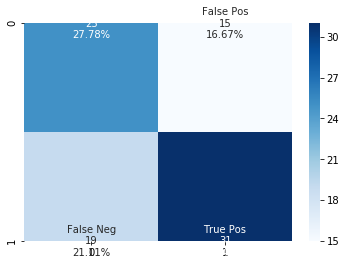

In [34]:
#Display confusion matrix
cf_matrix = metrics.confusion_matrix(y_fe_test, prediction)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
hide_toggle()

Gaussian Naive bayes classifier which is a parametric classifier and computes its predictions based on priors and assumes feature independence making it highly suitable for this problem. The NB classifier was fitted and tested on the training and test data respectively. It obtained an accuracy of 0.678, precision of 0.732, Recall of 0.680 and f-1 score of 0.701. This is the best result of all the models selected. 

In [35]:
#Apply gaussian naive bayes to fit train set and predic test set 
model = GaussianNB()

model.fit(x_fe_train,y_fe_train)
prediction = model.predict(x_fe_test)

#Display classification result
print("Accuracy:",metrics.accuracy_score(y_fe_test, prediction))
print("Precision:",metrics.precision_score(y_fe_test, prediction))
print("Recall:",metrics.recall_score(y_fe_test, prediction))
print("f1-score:",metrics.f1_score(y_fe_test, prediction))
hide_toggle()

Accuracy: 0.6777777777777778
Precision: 0.723404255319149
Recall: 0.68
f1-score: 0.7010309278350516


It performed best also in its validation score as well with a score of 0.757. This is extremely good relative to the CV scores of the other classifiers. 

In [36]:
#Determine validation score and displaying it 
validation_score = cross_val_score(model, x_fe_train , y_fe_train, cv = 10, scoring = 'accuracy').mean()
print('Gaussian Naive Bayes Validation score', validation_score)
hide_toggle()

Gaussian Naive Bayes Validation score 0.7571428571428571


The confusion matrix is displayed below and it performed well in both the true positive and true negative quadrants.

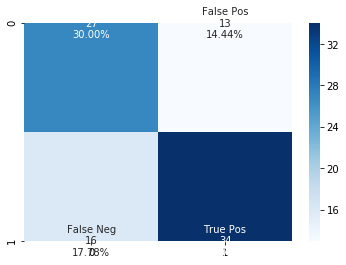

In [37]:
#Display confusion matrix 
cf_matrix = metrics.confusion_matrix(y_fe_test, prediction)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
hide_toggle()

Below is a summary of the classification performance of the classifiers. 


<b> Feature Engineered versus Non-Feature Engineered Image set using SVM Classifier </b> 

|  SVM  | Accuracy | Precision | Recall | F1 score | Cross-Validation score |
| --- | --- | --- | --- | --- | --- |
|  Non-FE  | 0.589 | 0.545 | 0.585 | 0.5465 | 0.576
| FE | 0.622 | 0.674 | 0.620 | 0.645 | 0.643 




<b> SVM versus Gaussian NB </b>

|  Classifier  | Accuracy | Precision | Recall | F1 score | Cross-Validation score |
| --- | --- | --- | --- | --- | --- |
|  Gaussian NB  | 0.678 | 0.723 | 0.680 | 0.701 | 0.757
| SVM | 0.622 | 0.674 | 0.620 | 0.645 | 0.643 



---
CONCLUSION
---

Even with a small dataset of images (300) and without neural networks, performing novel image processing and de-noising methods on the image dataset and using supervised machine learning classifiers provided an cross-validated accuracy of 0.757. This shows true potential in disease detection and prediction.

The results also show that the most important characteristics for identifying malignant moles are the intensity and shape of the lesions. There would certainly be an increase in accuracy if a larger dataset was used. 

Further research could also be done on how to better de-noise and process images and this would go a long way in bettering AI in all fields.